In [1]:
import pandas as pd
import numpy as np


from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.impute import SimpleImputer

## Load RAW Dataset

In [2]:
path = '../data/dataset/'

RAW_X_train = pd.read_csv(path+'RAW_X_train.csv', index_col='username', keep_default_na=False)
RAW_X_test = pd.read_csv(path+'RAW_X_test.csv', index_col='username', keep_default_na=False)
RAW_y_train = pd.read_csv(path+'RAW_y_train.csv', keep_default_na=False)
RAW_y_test = pd.read_csv(path+'RAW_y_test.csv', keep_default_na=False)

In [3]:
RAW_X_train.columns

Index(['is_name_social_political', 'desc', 'tweets', 'n_tweet',
       'quoted_tweets', 'n_tweet_use_hashtag', 'ratio_tweets_use_hashtag',
       'n_photo', 'n_video', 'buzzer', 'text_used'],
      dtype='object')

## Modeling and Evaluation (Multiple features)

In [4]:
def scoring(y_test, y_pred):
    
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"accuracy: {acc:.2f} | precision: {pre:.2f} | recall: {rec:.2f} | f score: {f1:.2f}")

In [5]:
preprocessor = ColumnTransformer(
    transformers=[
        ('combine_tweet', TfidfVectorizer(), 'text_used'),
        ('user_desc', TfidfVectorizer(), 'desc'),
        ('is_name', SimpleImputer(strategy='most_frequent'), ['is_name_social_political']),
        ('ratio', SimpleImputer(strategy='median'), ['ratio_tweets_use_hashtag']),
        ('numeric', StandardScaler(), ['n_tweet', 'n_photo', 'n_video'])
    ])

In [6]:
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=400, n_jobs=-1))
    ]
)

In [7]:
pipe.fit(RAW_X_train, RAW_y_train)

/home/ryx/miniconda3/lib/python3.8/site-packages/sklearn/pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('combine_tweet',
                                                  TfidfVectorizer(),
                                                  'text_used'),
                                                 ('user_desc',
                                                  TfidfVectorizer(), 'desc'),
                                                 ('is_name',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['is_name_social_political']),
                                                 ('ratio',
                                                  SimpleImputer(strategy='median'),
                                                  ['ratio_tweets_use_hashtag']),
                                                 ('numeric', StandardScaler(),
                                                  ['n_tweet', 'n_photo',
                 

In [8]:
RAW_y_pred = pipe.predict(RAW_X_test)

In [9]:
# Evaluate
scoring(RAW_y_test, RAW_y_pred)

accuracy: 0.84 | precision: 0.75 | recall: 0.33 | f score: 0.45


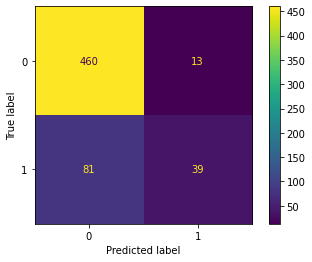

In [10]:
plot_confusion_matrix(pipe, RAW_X_test, RAW_y_test)

## ONLY Tweets text features

In [11]:
tfidf = TfidfVectorizer()
tfidf.fit(RAW_X_train.text_used)

X_train_txt = tfidf.transform(RAW_X_train.text_used)
X_test_txt = tfidf.transform(RAW_X_test.text_used)

In [12]:
model = RandomForestClassifier(n_estimators=400, n_jobs=-1)
model.fit(X_train_txt, RAW_y_train)

<ipython-input-12-8aa5eccff55a>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_txt, RAW_y_train)


RandomForestClassifier(n_estimators=400, n_jobs=-1)

In [13]:
y_pred_txt = model.predict(X_test_txt)
scoring(RAW_y_test, y_pred_txt)

accuracy: 0.84 | precision: 0.72 | recall: 0.35 | f score: 0.47


## Prepare TF-IDF dataset

In [14]:
tweet_vectorizer = TfidfVectorizer(max_features=50000)
desc_vectorizer = TfidfVectorizer(max_features=3000)

tweet_vectorizer.fit(RAW_X_train.text_used)
desc_vectorizer.fit(RAW_X_train.desc)

TfidfVectorizer(max_features=3000)

In [15]:
def feat_stack(X, y, tweet_vec, desc_vec):
    tweet_tfidf = tweet_vec.transform(X.text_used)
    desc_tfidf = desc_vec.transform(X.desc)
    
    numeric_feat = ['is_name_social_political', 'n_tweet', 'ratio_tweets_use_hashtag',
                'n_photo', 'n_video']
    numeric_arr = X[numeric_feat].to_numpy()
    
    label = X.buzzer.to_numpy().reshape(-1, 1)
    
    ready_data = np.hstack((numeric_arr, desc_tfidf.toarray(), 
                            tweet_tfidf.toarray()))
    return ready_data, label

In [16]:
X_train_tfidf, y_train_tfidf = feat_stack(RAW_X_train, RAW_y_train, tweet_vectorizer, desc_vectorizer)
X_test_tfidf, y_test_tfidf = feat_stack(RAW_X_test, RAW_y_test, tweet_vectorizer, desc_vectorizer)

In [17]:
data = {'X_train_tfidf.npy':X_train_tfidf, 'X_test_tfidf.npy':X_test_tfidf, 
        'y_train_tfidf.npy':y_train_tfidf, 'y_test_tfidf.npy':y_test_tfidf}

for key, value in data.items(): 
    with open('../data/dataset/'+key, 'wb') as f:
        np.save(f, value)